In [1]:
print("\n--- Bem vindo ao Projeto de Reconhecimento de Audio ---")
print("\nRealizando Imports de Libs necessarias...")

import librosa
import glob
import random
import re
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
# import scipy.signal as sg
# from scipy.fftpack import dct
# from scipy.fftpack import fft
# from scipy.fftpack import ifft
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix


--- Bem vindo ao Projeto de Reconhecimento de Audio ---

Realizando Imports de Libs necessarias...


In [2]:
# calculo do Chroma Energy Normalized Statistics (CENS) do sinal
def calc_chroma(segmento, sr):
    av = segmento.to_numpy(copy=True)
    return np.mean(librosa.feature.chroma_cqt(y=av, sr=sr, n_chroma=24).T, axis=0)

# calculo do Mel Spectrogram do sinal
def calc_mel(segmento, sr):
    av = segmento.to_numpy(copy=True)
    return np.mean(librosa.feature.melspectrogram(av, sr=sr).T, axis=0)

# calculo do MFCC medio para cada audio de entrada
def calc_mfcc(segmento, sr):
    av = segmento.to_numpy(copy=True)
    return np.mean(librosa.feature.mfcc(y=av, sr=sr, n_mfcc=24).T, axis=0)

In [3]:
# realiza a extracao de features do sinal
def feature_extraction(segmento, sr):
    features = []
    np.array(features)

    features = np.append(features, calc_mfcc(segmento, sr))
    features = np.append(features, calc_mel(segmento, sr))
    features = np.append(features, calc_chroma(segmento, sr))
    """
    features = np.append(features, calc_dct(segmento))
    features = np.append(features, calc_fft(segmento))
    """
    return features

# divisao dos audios de entrada para separacao de cada letra
def extract_intervals(signal, cut):
    data_interval = []
    interval = int(len(signal) // cut)
    for i in range(0, cut) :
        data_interval.append(pd.Series(signal[i*interval : (i+1)*interval]))
    return data_interval

In [4]:
# quebra o nome do arquivo em letras para categorizacao dos audios
def get_labels(path_file):
    path_file = re.sub("[ (1)]", "", path_file)
    return list(path_file[-8:-4])

# faz a aquisicao do caminho de todos os arquivos na pasta path
def get_files(path):
    files = glob.glob(path + "*.wav")
    return files

def get_x_y(path, reduce=False):
    files = get_files(path)
    Xt = []
    yt = []
    segmentos = []
    seed = random.randint(1, 1000)
    random.seed(seed)
    random.shuffle(files)
    # print(f"Semente gerada: {seed}\n")
    i = 0
    for f in files:
        data, sr = librosa.load(f, mono=True)
        segmentos += extract_intervals(data, 4)
        yt += get_labels(f)
        # print(i)
        if i > 30 and reduce:
            break    
        i += 1
        

    for segmento in segmentos:
        Xt.append(feature_extraction(segmento, sr))
    
    return Xt,yt

In [15]:
# lista os elementos (caracteres) unicos de um array
def unique_values(l):
    unique_list = []
    for x in l: 
        if x not in unique_list: 
            unique_list.append(x)
    return unique_list


# gera e imprime a matriz de confusao geral do modelo
def print_conf_mtx(yt, y_pred, labels, classifier):
    print(labels)
    print()
    cm = confusion_matrix(yt, y_pred, labels)
    print(cm)
    """
    print("\nMatrizes de Confusao Individuais")
    print(multilabel_confusion_matrix(yt, y_pred))
    """
    
    print("\nPlotando Confusion Matrix geral usando o matplotlib...")
    print("Feche o arquivo de saída para continuar a execução")

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the ' + classifier + ' classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.locator_params(nbins=len(labels))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig('confusion_matrix_'+ classifier +'.png')
    plt.show()

In [6]:
train_path = 'TREINAMENTO/'
validation_path= 'VALIDACAO/'
test_path = 'TESTE'

In [7]:
print(f"\nBuscando dados nas Pastas {train_path} e {validation_path} internas do projeto...")

print("\nPreparando DataSet para Treino")
X, y = get_x_y(train_path)
# X, y = get_x_y(train_path, True)
print("Preparando DataSet para Teste/Validacao")
Xt, yt = get_x_y(validation_path)
# Xt, yt = get_x_y(validation_path, True)


Buscando dados nas Pastas TREINAMENTO/ e VALIDACAO/ internas do projeto...

Preparando DataSet para Treino
Preparando DataSet para Teste/Validacao


In [54]:
from sklearn.model_selection import GridSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [60]:
rf = RandomForestClassifier()

rf_random = GridSearchCV(estimator = rf, param_grid = random_grid, cv = 3, verbose=2, n_jobs = -1)
# Fit the random search model
rf_random.fit(X, y)

print(rf_random.best_params_)

Fitting 3 folds for each of 3960 candidates, totalling 11880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


KeyboardInterrupt: 

In [24]:
print(rf_random.best_score_)
best_rf = rf_random.best_estimator_

0.7050561797752809


In [31]:
rf_cv = pd.DataFrame(rf_random.cv_results_)

In [36]:
rf_als = rf_cv[['param_n_estimators','param_max_depth','mean_test_score']]

In [25]:
print("\nInstanciando Modelo Random Forest (n_estimators = 500 e max_depth = 50)")
# rfc = RandomForestClassifier(n_estimators = 500, max_depth = 50, random_state = 0)
rfc = best_rf


Instanciando Modelo Random Forest (n_estimators = 500 e max_depth = 50)


In [9]:
print("\nTreinando Modelo...")
rfc.fit(X, y)


Treinando Modelo...


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [26]:
print("Realizando Classificacao...")
y_rfc = rfc.predict(Xt)

Realizando Classificacao...


In [27]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
rfc_score = rfc.score(Xt, yt)
print(f"\nAcuracia do modelo Random Forest = {rfc_score:{4}.{4}}\n")

print("Relatorio de Classificacao")
print(classification_report(yt, y_rfc))


Acuracia do modelo Random Forest = 0.7481

Relatorio de Classificacao
              precision    recall  f1-score   support

           6       0.72      0.82      0.77       100
           7       0.94      0.95      0.94       114
           a       0.97      0.93      0.95        97
           b       0.55      0.63      0.59       106
           c       0.83      0.71      0.76       107
           d       0.57      0.54      0.55       110
           h       0.91      0.95      0.93       122
           m       0.51      0.56      0.53       104
           n       0.59      0.48      0.53       113
           x       0.91      0.94      0.92        95

    accuracy                           0.75      1068
   macro avg       0.75      0.75      0.75      1068
weighted avg       0.75      0.75      0.75      1068



Matriz de Confusao Geral do Modelo Random Forest

['c', 'n', '6', 'x', 'h', 'm', 'd', 'b', 'a', '7']

[[ 68   0  30   3   0   1   0   2   0   3]
 [  0  53   3   0   0  48   2   6   0   1]
 [ 14   0  79   5   0   0   0   1   0   1]
 [  1   0   3  90   0   0   0   1   0   0]
 [  0   0   0   0 117   0   1   0   3   1]
 [  0  29   0   1   0  54   9  10   0   1]
 [  0   4   1   0   0   7  53  44   0   1]
 [  1   1   1   0   0   7  28  68   0   0]
 [  0   0   0   0   4   0   0   0  93   0]
 [  3   0   1   2   1   0   0   0   0 107]]

Plotando Confusion Matrix geral usando o matplotlib...
Feche o arquivo de saída para continuar a execução


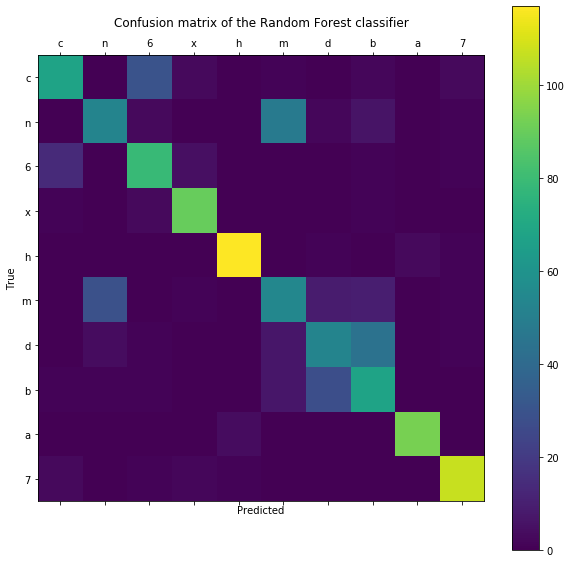

In [17]:
labels = unique_values(y)
print("Matriz de Confusao Geral do Modelo Random Forest\n")
print_conf_mtx(yt, y_rfc, labels, "Random Forest")